In [53]:
# === Ignorar advertencias ===
import warnings
warnings.filterwarnings('ignore')

# === Manejo del sistema y utilidades ===
import os
import ast
from itertools import product
from tqdm import tqdm

# === Manipulación de datos ===
import numpy as np
import pandas as pd

# === Visualización ===
import matplotlib.pyplot as plt

# === Preprocesamiento y métricas ===
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# === Diagnóstico estadístico ===
from statsmodels.stats.diagnostic import acorr_ljungbox

# === Redes neuronales (Keras / TensorFlow) ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
import tensorflow as tf


In [17]:
# Listar dispositivos disponibles
devices = tf.config.list_physical_devices('GPU')

if devices:
    print(f"TensorFlow está utilizando la GPU: {devices}")
else:
    print("TensorFlow no está utilizando la GPU")

TensorFlow está utilizando la GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Lectura de datos

In [18]:
df = pd.read_csv('./datasets/data_treino_dv_df_2000_2010.csv')
df.head(1)

,HORA (UTC),"VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))","VENTO, VELOCIDADE HORARIA (m/s)",UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C),TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C),"UMIDADE RELATIVA DO AR, HORARIA (%)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)","PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)","VENTO, RAJADA MAXIMA (m/s)",PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,61.0,888.2,0.0,3.8,888.2,887.7


In [19]:
df.columns = ['HORA','WIND_DIR_HOR','WIND_VEL_HOR','HUM_REL_MAX_ANT','HUM_REL_MIN_ANT','TEMP_MAX_ANT','TEMP_MIN_ANT','HUM_REL_HOR','PRES_ATM_NIV','PREC_HOR','RAFAGA_VIENTO','PRES_ATM_MAX_ANT','PRES_ATM_MIN_ANT']
df.head(2)

,HORA,WIND_DIR_HOR,WIND_VEL_HOR,HUM_REL_MAX_ANT,HUM_REL_MIN_ANT,TEMP_MAX_ANT,TEMP_MIN_ANT,HUM_REL_HOR,PRES_ATM_NIV,PREC_HOR,RAFAGA_VIENTO,PRES_ATM_MAX_ANT,PRES_ATM_MIN_ANT
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,61.0,888.2,0.0,3.8,888.2,887.7
1,13:00,0.965926,2.7,62.0,55.0,24.2,22.5,55.0,888.4,0.0,4.7,888.4,888.2


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87693 entries, 0 to 87692
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HORA              87693 non-null  object 
 1   WIND_DIR_HOR      87693 non-null  float64
 2   WIND_VEL_HOR      87693 non-null  float64
 3   HUM_REL_MAX_ANT   87693 non-null  float64
 4   HUM_REL_MIN_ANT   87693 non-null  float64
 5   TEMP_MAX_ANT      87693 non-null  float64
 6   TEMP_MIN_ANT      87693 non-null  float64
 7   HUM_REL_HOR       87693 non-null  float64
 8   PRES_ATM_NIV      87693 non-null  float64
 9   PREC_HOR          87693 non-null  float64
 10  RAFAGA_VIENTO     87693 non-null  float64
 11  PRES_ATM_MAX_ANT  87693 non-null  float64
 12  PRES_ATM_MIN_ANT  87693 non-null  float64
dtypes: float64(12), object(1)
memory usage: 8.7+ MB


In [21]:
df.drop(columns='HORA', inplace= True)

## Prueba de Modelos ANN

A continuación se realizan pruebas individuales de los modelos MLP, RNN y LSTM para obtener una idea de que parametros se ajustan mejor al problema. Posteriormente, por medio de un search más extensivo se buscara los parametros que ofrezcan mejores resultados.

### MLP

#### Ventana de tiempo 7 días

1/1 [==============================] - 0s 38ms/step


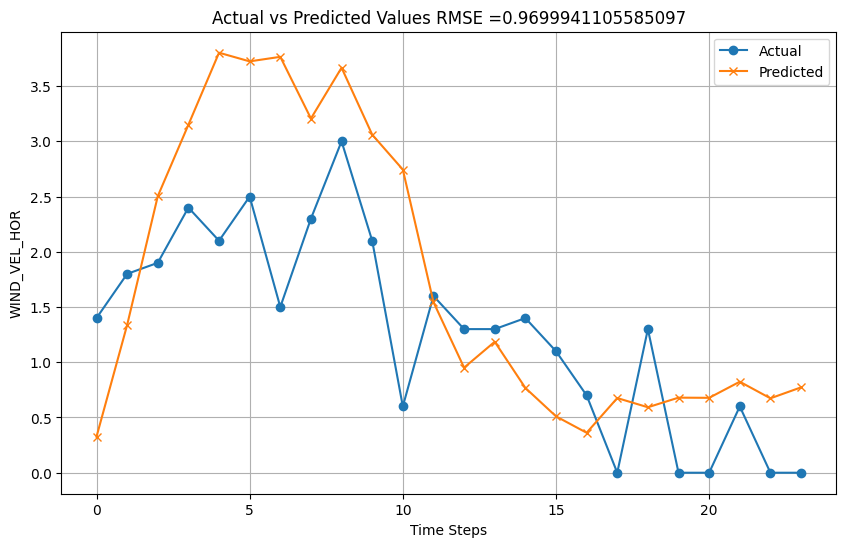

1/1 [==============================] - 0s 39ms/step


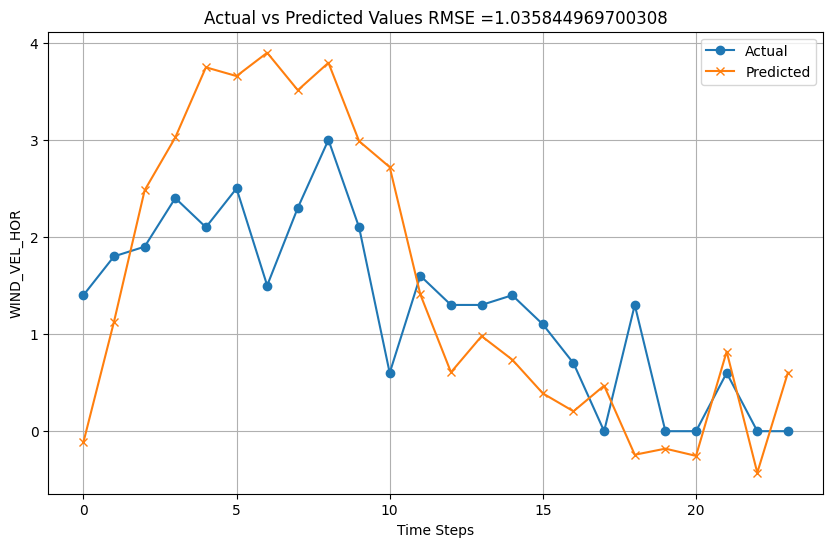

1/1 [==============================] - 0s 43ms/step


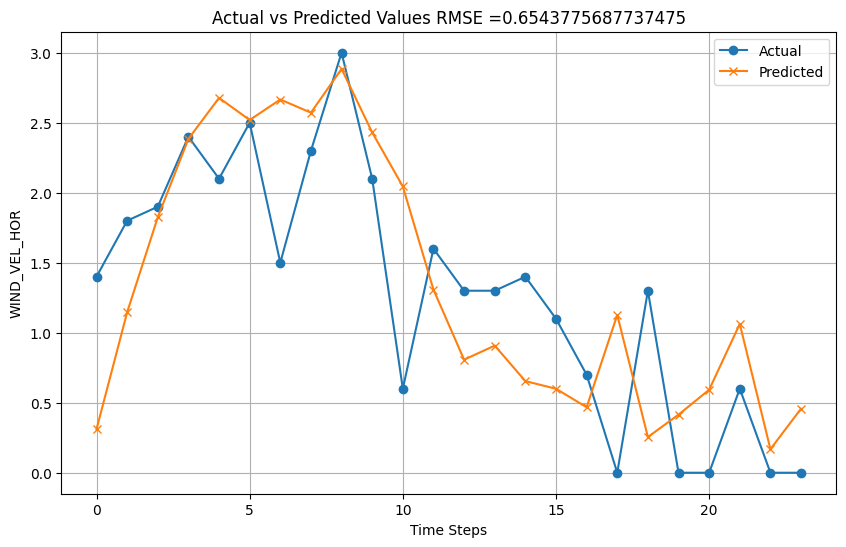

1/1 [==============================] - 0s 41ms/step


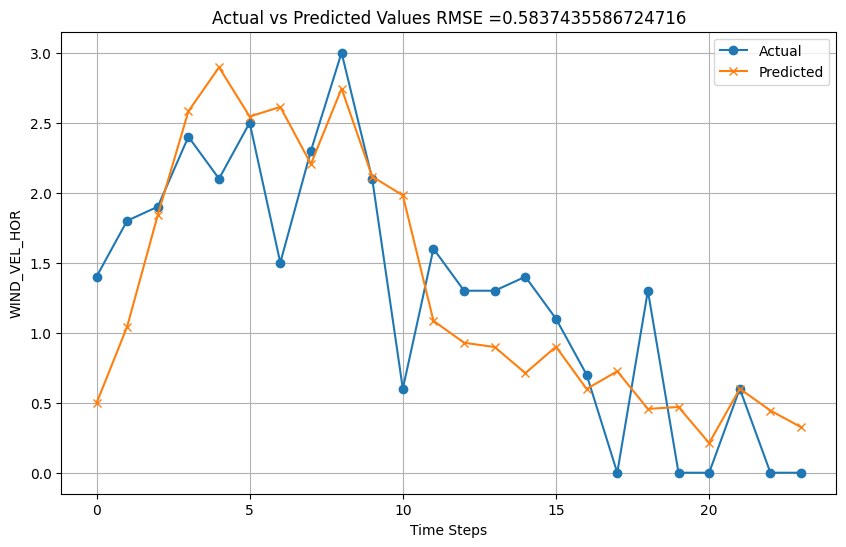

1/1 [==============================] - 0s 49ms/step


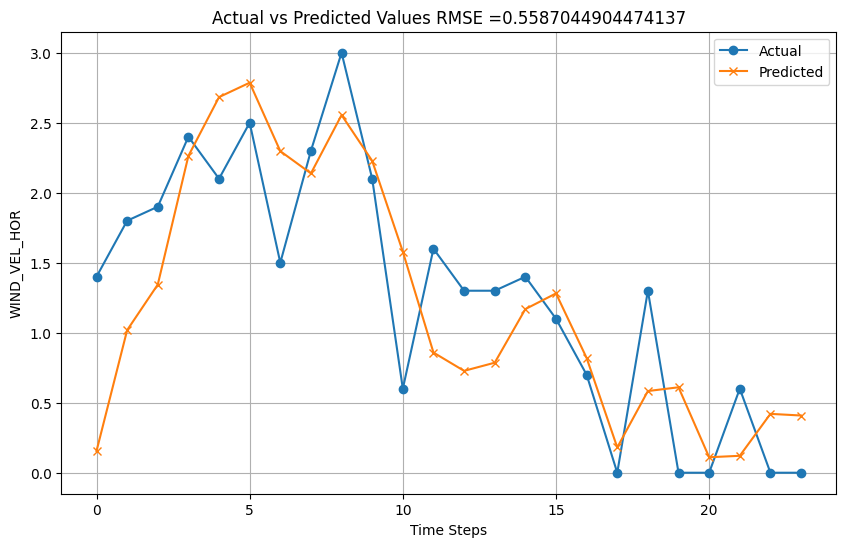

1/1 [==============================] - 0s 40ms/step


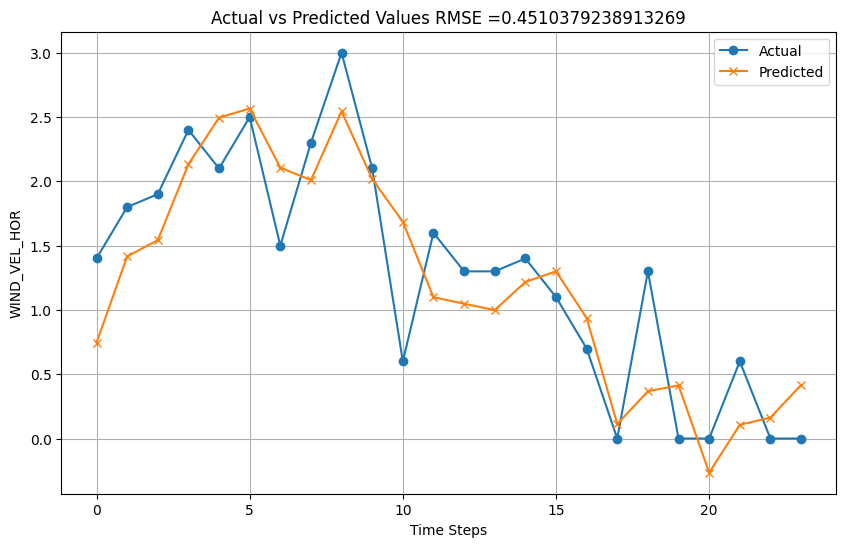

In [60]:
target_col = 'WIND_VEL_HOR'
window = 7
start = 2000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24

# Train Test +  Escalado
train = df.iloc[start: start + T_hours]
test = df.iloc[start + T_hours: start + T_hours + test_hours]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Duplicando neuronas 1 sola capa
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Adicionando otra capa oculta
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Mas neuronas en las capas
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'relu'), #Capa oculta
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(16, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion + mas neuronas en las capas
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'tanh'), #Capa oculta
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

#### Ventana de tiempo 14 días

1/1 [==============================] - 0s 38ms/step


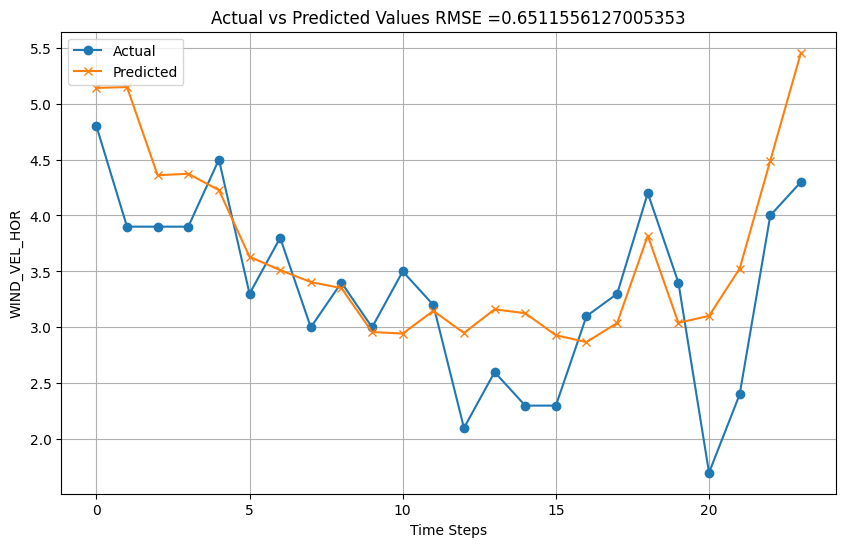

1/1 [==============================] - 0s 37ms/step


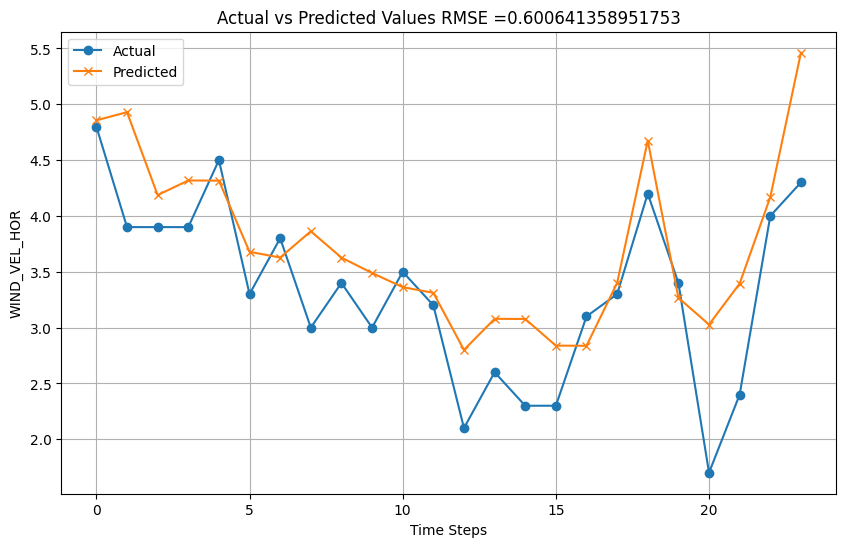

1/1 [==============================] - 0s 42ms/step


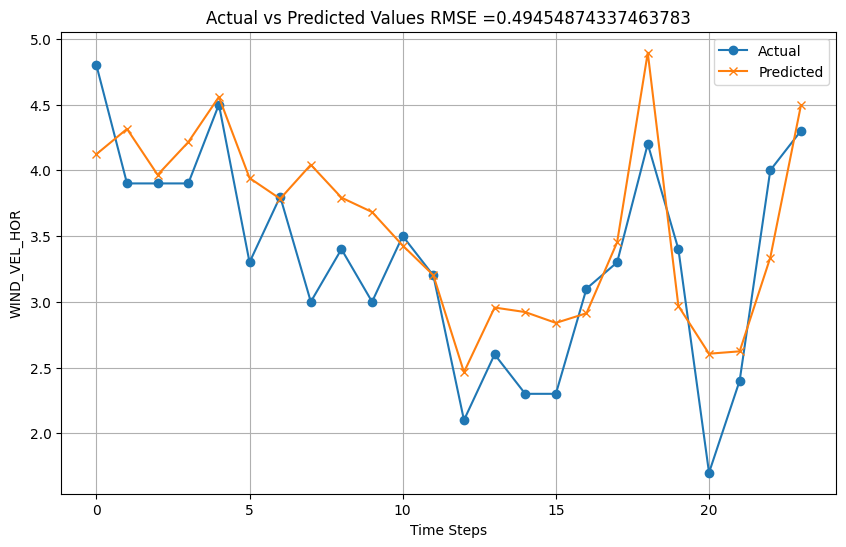

1/1 [==============================] - 0s 43ms/step


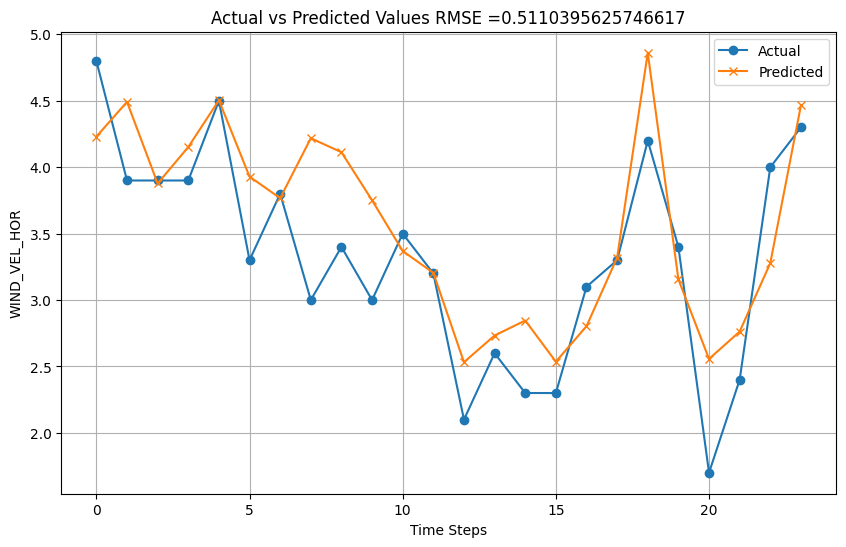

1/1 [==============================] - 0s 44ms/step


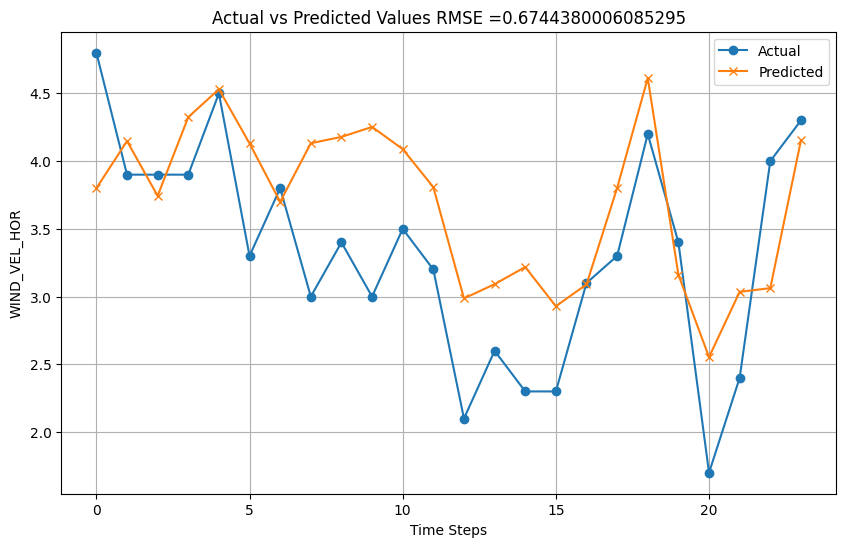

1/1 [==============================] - 0s 47ms/step


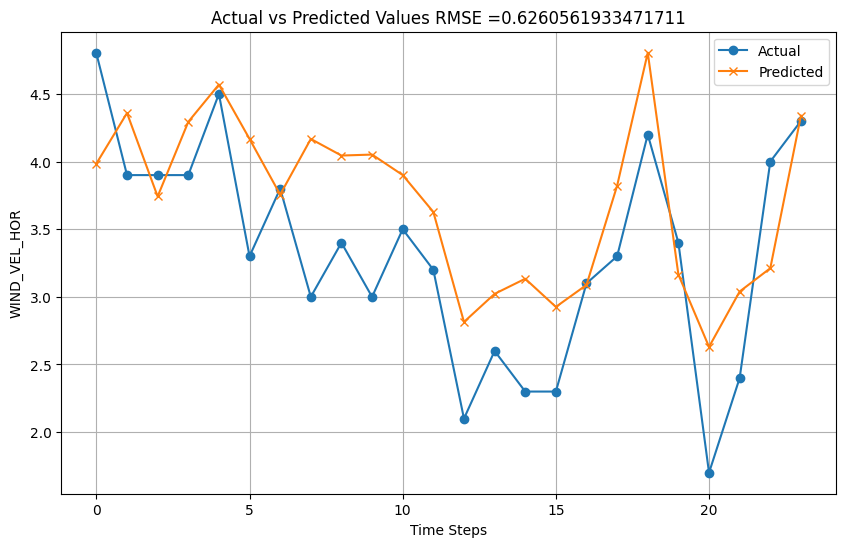

In [62]:
target_col = 'WIND_VEL_HOR'
window = 14
start = 1000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24

# Train Test +  Escalado
train = df.iloc[start: start + T_hours]
test = df.iloc[start + T_hours: start + T_hours + test_hours]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Duplicando neuronas 1 sola capa
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Adicionando otra capa oculta
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Mas neuronas en las capas
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'relu'), #Capa oculta
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(16, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion + mas neuronas en las capas
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'tanh'), #Capa oculta
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

#### Ventana de tiempo 21 días

1/1 [==============================] - 0s 39ms/step


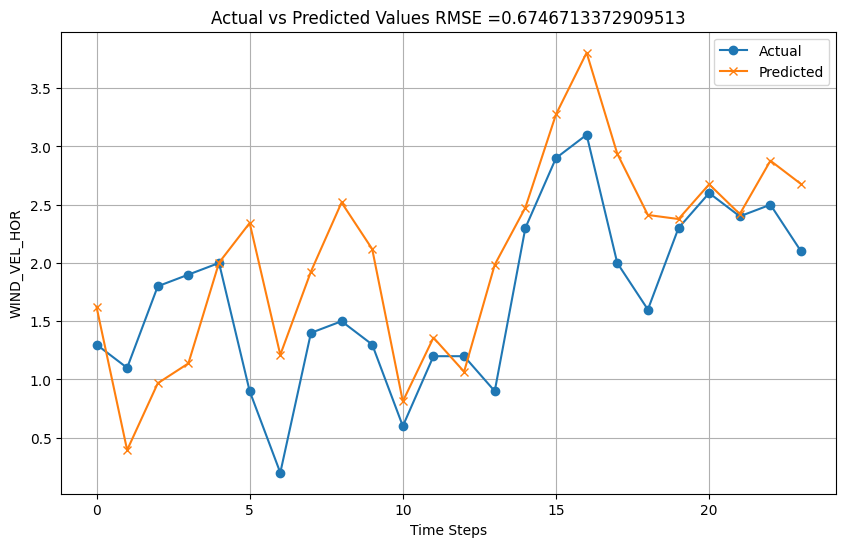

1/1 [==============================] - 0s 33ms/step


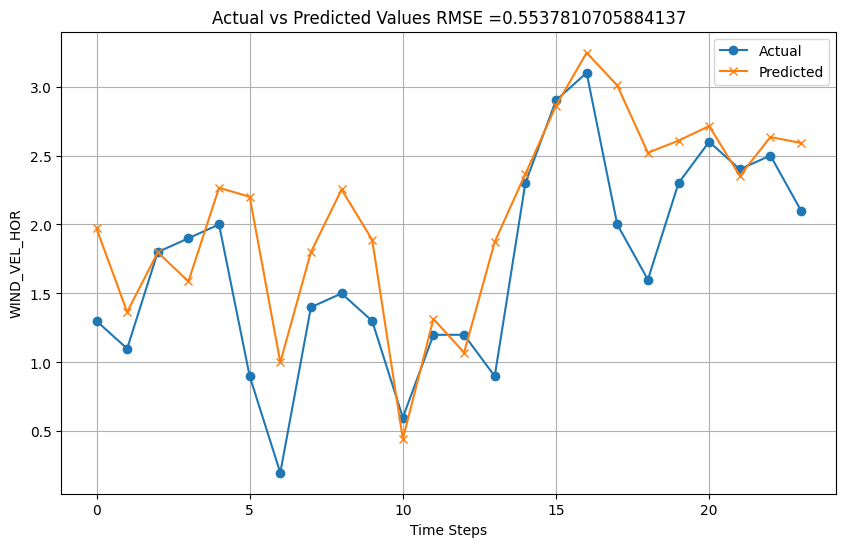

1/1 [==============================] - 0s 40ms/step


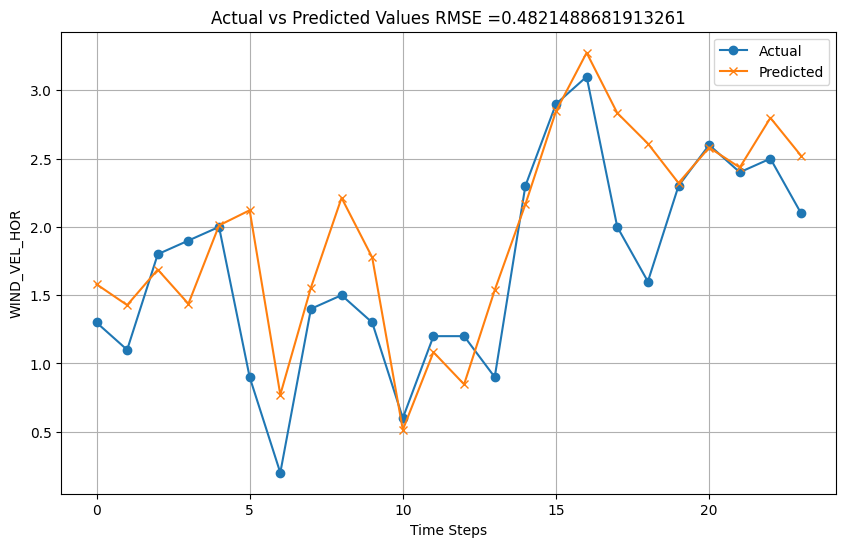

1/1 [==============================] - 0s 43ms/step


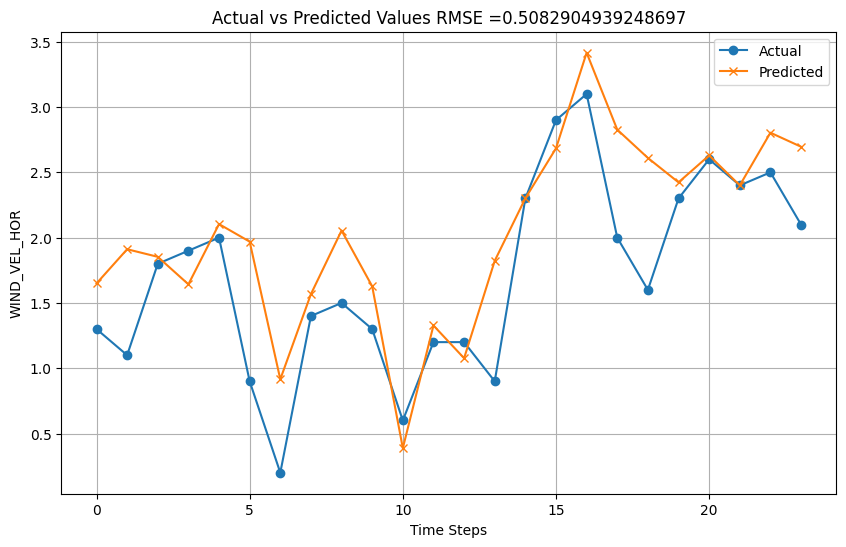

1/1 [==============================] - 0s 39ms/step


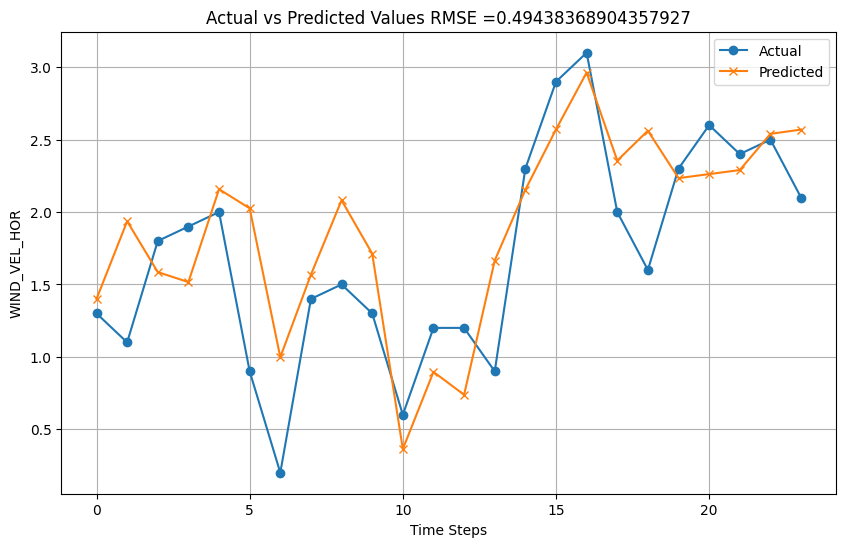

1/1 [==============================] - 0s 52ms/step


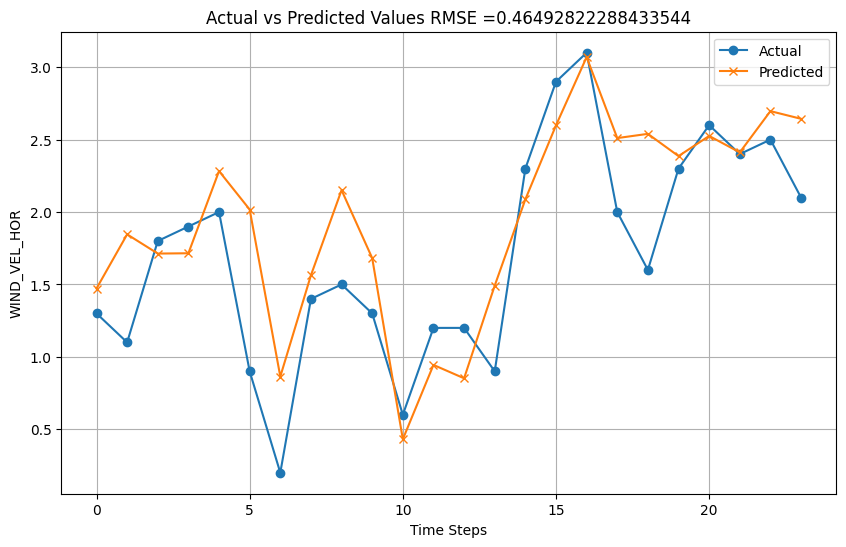

In [64]:
target_col = 'WIND_VEL_HOR'
window = 21
start = 2000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24

# Train Test +  Escalado
train = df.iloc[start: start + T_hours]
test = df.iloc[start + T_hours: start + T_hours + test_hours]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Duplicando neuronas 1 sola capa
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Adicionando otra capa oculta
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Mas neuronas en las capas
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'relu'), #Capa oculta
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(16, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion + mas neuronas en las capas
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'tanh'), #Capa oculta
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Modelos con escalamiento de variables

Los siguientes modelos requieren escalamiento de las variables predictoras, por lo que se trabajan en la misma función

* KNeighboors (vecinos mas cercanos)
* Maquinas de soporte vectoriales

In [10]:
# Construye un modelo Multilayer Perceptron (MLP) para regresión

def build_mlp_model(input_dim, hidden_layers, activation='relu', learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation=activation))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Construye un modelo RNN simple con una sola capa recurrente

def build_rnn_model(timesteps, input_dim, hidden_units, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation, input_shape=(timesteps, input_dim)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Construye un modelo LSTM para capturar relaciones temporales largas

def build_lstm_model(timesteps, input_dim, hidden_units, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units, activation=activation, input_shape=(timesteps, input_dim)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Genera secuencias de datos para modelos RNN o LSTM

def create_rnn_sequences(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq = df.iloc[i:i+window_size]
        X.append(seq.drop(columns=[target_col]).values)
        y.append(df.iloc[i+window_size][target_col])
    return np.array(X), np.array(y)

# Función principal para entrenamiento y evaluación de MLP, RNN y LSTM con sliding windows

def sliding_window_regression_models_scaling_keras_rnn(
    df,
    target_col='WIND_VEL_HOR',
    T_values=[7, 14],
    test_window=1,
    model_types=['MLP', 'RNN', 'LSTM'],
    mlp_params={
        'hidden_layers': [[16], [32], [64]],
        'activation': ['relu'],
        'learning_rate': [0.001],
        'epochs': [50],
        'batch_size': [32]
    },
    rnn_params={
        'hidden_units': [16, 32],
        'activation': ['tanh'],
        'learning_rate': [0.001],
        'epochs': [50],
        'batch_size': [32]
    },
    lstm_params={
        'hidden_units': [32, 64],
        'activation': ['tanh'],
        'learning_rate': [0.001],
        'epochs': [50],
        'batch_size': [32]
    },
    save_path='./progreso_keras_rnn'
):
    # Crea carpeta de resultados si no existe
    os.makedirs(save_path, exist_ok=True)
    resultados_por_T = {}

    # Itera sobre diferentes ventanas de entrenamiento T
    for T in tqdm(T_values, desc="Procesando ventanas T", unit="ventana"):
        T_hours = T * 24
        test_hours = test_window * 24
        total_windows = len(df) - T_hours - test_hours + 1
        output_path = os.path.join(save_path, f'ANN_resultados_T{T}.csv')

        # Carga resultados previos si existen para evitar cálculos redundantes
        if os.path.exists(output_path):
            df_prev = pd.read_csv(output_path)
            if 'params' in df_prev:
                df_prev['params'] = df_prev['params'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        else:
            df_prev = pd.DataFrame(columns=[
                'modelo', 'params', 'T_dias', 'T_horas', 'MAPE', 'MAE', 'RMSE', 'MSE', 'R2', 'LjungBox_p'
            ])

        # Itera sobre MLP, RNN o LSTM
        for model_type in model_types:
            if model_type == 'MLP':
                param_grid = list(product(*mlp_params.values()))
                param_keys = list(mlp_params.keys())
            elif model_type == 'RNN':
                param_grid = list(product(*rnn_params.values()))
                param_keys = list(rnn_params.keys())
            elif model_type == 'LSTM':
                param_grid = list(product(*lstm_params.values()))
                param_keys = list(lstm_params.keys())

            # Itera sobre combinaciones de hiperparámetros
            for combo in param_grid:
                param_dict = dict(zip(param_keys, combo))
                print(f"🔧 Evaluando modelo {model_type} con hiperparámetros: {param_dict}")
                param_dict = dict(zip(param_keys, combo))
                if not df_prev.empty and ((df_prev['modelo'] == model_type) & (df_prev['params'].apply(lambda p: p == param_dict))).any():
                    continue

                resultados = {k: [] for k in ['MAPE', 'MAE', 'RMSE', 'MSE', 'R2', 'LjungBox_p']}

                # Sliding window sobre el conjunto de datos
                for start in range(0, total_windows, 24):
                    if model_type == 'MLP':
                        train = df.iloc[start: start + T_hours]
                        test = df.iloc[start + T_hours: start + T_hours + test_hours]

                        X_train = train.drop(columns=[target_col])
                        y_train = train[target_col]
                        X_test = test.drop(columns=[target_col])
                        y_test = test[target_col]

                        scaler = StandardScaler()
                        X_train = scaler.fit_transform(X_train)
                        X_test = scaler.transform(X_test)

                        model = build_mlp_model(
                            input_dim=X_train.shape[1],
                            hidden_layers=param_dict['hidden_layers'],
                            activation=param_dict['activation'],
                            learning_rate=param_dict['learning_rate']
                        )

                        early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
                        model.fit(X_train, y_train, epochs=param_dict['epochs'], batch_size=param_dict['batch_size'], verbose=0, callbacks=[early_stop])
                        y_pred = model.predict(X_test).flatten()

                    else:
                        # Escalamiento sin data leakage para RNN/LSTM
                        data_window = df.iloc[start: start + T_hours + test_hours].copy()
                        train_data = data_window.iloc[:T_hours]
                        test_data = data_window.iloc[T_hours:]

                        scaler = StandardScaler()
                        X_train_scaled = scaler.fit_transform(train_data.drop(columns=[target_col]))
                        X_test_scaled = scaler.transform(test_data.drop(columns=[target_col]))

                        train_scaled = pd.DataFrame(X_train_scaled, columns=train_data.columns.drop(target_col))
                        train_scaled[target_col] = train_data[target_col].values

                        test_scaled = pd.DataFrame(X_test_scaled, columns=test_data.columns.drop(target_col))
                        test_scaled[target_col] = test_data[target_col].values

                        scaled = pd.concat([train_scaled, test_scaled])
                        X, y = create_rnn_sequences(scaled, target_col, T_hours)
                        X_train, y_train = X[:-1], y[:-1]
                        X_test, y_test = X[-1:], y[-1:]

                        if model_type == 'RNN':
                            model = build_rnn_model(
                                timesteps=X_train.shape[1],
                                input_dim=X_train.shape[2],
                                hidden_units=param_dict['hidden_units'],
                                activation=param_dict['activation'],
                                learning_rate=param_dict['learning_rate']
                            )
                        else:  # LSTM
                            model = build_lstm_model(
                                timesteps=X_train.shape[1],
                                input_dim=X_train.shape[2],
                                hidden_units=param_dict['hidden_units'],
                                activation=param_dict['activation'],
                                learning_rate=param_dict['learning_rate']
                            )

                        early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
                        model.fit(X_train, y_train, epochs=param_dict['epochs'], batch_size=param_dict['batch_size'], verbose=0, callbacks=[early_stop])
                        y_pred = model.predict(X_test).flatten()

                    # Cálculo de métricas
                    residuals = y_test.values - y_pred if hasattr(y_test, 'values') else y_test - y_pred
                    resultados['MAPE'].append(mean_absolute_percentage_error(y_test, y_pred))
                    resultados['MAE'].append(mean_absolute_error(y_test, y_pred))
                    resultados['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
                    resultados['MSE'].append(mean_squared_error(y_test, y_pred))
                    resultados['R2'].append(r2_score(y_test, y_pred))
                    if model_type == 'MLP' and len(residuals) >= 2:
                        ljung_p = acorr_ljungbox(residuals, lags=[1], return_df=True)['lb_pvalue'].iloc[0]
                    else:
                        ljung_p = np.nan
                    resultados['LjungBox_p'].append(ljung_p)

                # Registro y guardado de resultados por combinación
                nuevo_row = pd.DataFrame([{
                    'modelo': model_type,
                    'params': param_dict,
                    'T_dias': T,
                    'T_horas': T_hours,
                    'MAPE': np.mean(resultados['MAPE']),
                    'MAE': np.mean(resultados['MAE']),
                    'RMSE': np.mean(resultados['RMSE']),
                    'MSE': np.mean(resultados['MSE']),
                    'R2': np.mean(resultados['R2']),
                    'LjungBox_p': np.nanmean(resultados['LjungBox_p'])
                }])
                df_prev = pd.concat([df_prev, nuevo_row], ignore_index=True)
                print(f"✅ Finalizado {model_type} con RMSE promedio: {np.mean(resultados['RMSE']):.4f}")
                df_prev.to_csv(output_path, index=False)

        resultados_por_T[T] = df_prev

    return resultados_por_T


In [11]:
resultados_por_T = sliding_window_regression_models_scaling_keras_rnn(df, target_col='WIND_VEL_HOR')

# Ver los DataFrames en memoria
df_w_7 = resultados_por_T[7]    # Para T=7 días
df_w_14 = resultados_por_T[14]    # Para T=7 días
df_w_21 = resultados_por_T[21]    # Para T=7 días


Procesando ventanas T:   0%|          | 0/2 [00:00<?, ?ventana/s]

🔧 Evaluando modelo MLP con hiperparámetros: {'hidden_layers': [16], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}
🔧 Evaluando modelo MLP con hiperparámetros: {'hidden_layers': [32], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}
1/1 [==============================] - 0s 53ms/step
✅ Finalizado MLP con RMSE promedio: 1.0953
🔧 Evaluando modelo MLP con hiperparámetros: {'hidden_layers': [64], 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}
1/1 [==============================] - 0s 54ms/step


Procesando ventanas T:   0%|          | 0/2 [1:57:13<?, ?ventana/s]


KeyboardInterrupt: 

In [ ]:
# Ordenar por RMSE de mayor a menor
df_w_7_sorted = df_w_7.sort_values(by="RMSE", ascending=True)

# Etiquetas combinadas modelo + params
etiquetas = df_w_7_sorted['modelo'].astype(str) + ' ' + df_w_7_sorted['params'].astype(str)

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.bar(etiquetas, df_w_7_sorted['RMSE'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('RMSE por Modelo - T=7 días (ordenado de mayor a menor)')
plt.tight_layout()
plt.show()

## KNeighboors

Hay que normalizar datos por eso se hace por aparte

En principio, hay dos parámetros importantes en el clasificador KNeighbors: el número de vecinos y cómo se mide la distancia entre los puntos de datos. En la práctica, utilizar un número pequeño de vecinos, como tres o cinco, suele funcionar bien, pero se debería ajustar este parámetro.

La elección de la medida de distancia correcta es también crucial. Por defecto, KNeighbors utiliza la distancia euclidiana, que funciona bien en muchos casos. Uno de los puntos fuertes de 
-NN es que el modelo es muy fácil de entender, y a menudo da un rendimiento razonable sin necesidad de muchos ajustes. El uso de este algoritmo es un buen método de referencia para probar, antes de considerar técnicas más avanzadas.

La construcción del modelo de vecinos más cercanos suele ser muy rápida, pero cuando el conjunto de entrenamiento es muy grande (ya sea en número de características o en número de muestras) la predicción puede ser lenta. Cuando se utiliza el algoritmo 
-NN, es importante pre-procesar los datos, tema que revisaremos en secciones posteriores. Este enfoque no suele funcionar bien en conjuntos de datos con muchas características (cientos o más), y lo hace especialmente mal con conjuntos de datos en los que la mayoría de las características son 0 la mayor parte del tiempo (los llamados conjuntos de datos dispersos).

Por lo tanto, aunque el algoritmo de 
-vecinos más cercanos es fácil de entender, no se utiliza a menudo en la práctica, debido a que la predicción es lenta y a su incapacidad para manejar muchas características.

## Dudas para el profesor

1. El fit del escalador se debe realizar con los datos de train, y con ese trabajar tanto train como test? Como se hace en producción??